In [2]:
import numpy as np
import ast
import scipy   
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2     
from keras.preprocessing import image    
from keras.models import Model   
import sys


In [4]:
model = tf.keras.models.load_model('saved_model/my_model')


In [7]:
model.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv_9 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_9 (TFOpLam  (None, 224, 224, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 layer_4 (Layer)             (None, 7, 7, 1280)        0         
                                                           

In [5]:
out1 = model.layers[-4].output

out2 = model.layers[-1].output


model = tf.keras.Model(inputs=model.input, 
    outputs=(out1, out2)) 



In [6]:
# img = cv2.imread("test_images/dress.jpg")
img = cv2.imread("test_images/blazer.jpeg")

resized = cv2.resize(img, (224, 224))
reshaped = resized.reshape(1, 224, 224, 3)

In [7]:
all_amp_layer_weights = model.layers[-1].get_weights()[0]
labels = ['Blazer','Dress','Hat','Hoodie', 'Longsleeve','Pants', 'Polo','Shirt','Shoes','Shorts', 'Skirt','T-Shirt','Undershirt']


In [8]:
last_conv_output, pred_vec = model.predict(reshaped)
# print(last_conv_output.shape)
print(pred_vec)

# change dimensions of last convolutional outpu tto 7 x 7 x 2048
last_conv_output = np.squeeze(last_conv_output) 
# print(last_conv_output.shape)

# get model's prediction 
pred = np.argmax(pred_vec)
print(pred, pred_vec[0][pred],labels[pred])

# bilinear upsampling to resize each filtered image to size of original image 
mat_for_mult = scipy.ndimage.zoom(last_conv_output, (32, 32, 1), order=1) 

final_arr = []
threshold = 0.3

for val in pred_vec[0]:
    if val > threshold:
        index_of = np.where(pred_vec[0]==val)
        # get AMP layer weights
        amp_layer_weights = all_amp_layer_weights[:, index_of[0][0]]  

        # get class activation map for object class that is predicted to be in the image
        final_output = np.dot(mat_for_mult.reshape((224*224, 1280)), amp_layer_weights).reshape(224,224) # dim: 224 x 224
        final_arr.append(final_output)




2022-05-02 17:15:43.855610: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


[[6.9870192e-01 1.8414604e-02 2.2813858e-04 9.4446903e-03 2.0262443e-01
  6.0181081e-04 7.9651241e-04 6.1344583e-02 7.7888500e-03 2.6623527e-05
  6.5061949e-06 4.0736750e-06 1.7297118e-05]]
0 0.6987019 Blazer


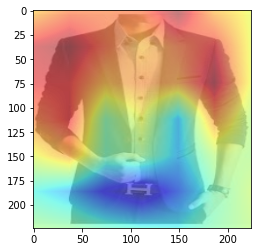

In [9]:
fig, ax = plt.subplots()

for item in final_arr:
    # load image, convert BGR --> RGB, resize image to 224 x 224,
    im = cv2.resize(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), (224, 224))
    # plot image
    ax.imshow(im, alpha=0.5)

    # plot class activation map
    ax.imshow(final_arr[0], cmap='jet', alpha=0.5)